# 5300 Final Project

Create classes to solve the double pendlum problem and the two-body problem for gravitational attraction.

In [31]:
%matplotlib inline

In [32]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

## The Equation of Motion for a Double Pendulum
We start with Taylor equations (11.37) and (11.38):

$\begin{align}
  U(\phi_1, \phi_2) = (m_1 + m _2) g L_1 (1 - \cos \phi_1) + m_2 g L_2 (1-\cos \phi_2)
\end{align}$

$\begin{align}
  T = \frac{1}{2} (m_1 + m _2) L_1^2 \dot \phi_1^2 +
  m_2 L_1 L_2 \dot \phi_1 \dot \phi_2 \cos (\phi_1 - \phi_2) +
  \frac{1}{2} m_2 L_2^2 \dot \phi_2^2
\end{align}$

$\begin{align}
  L = T - U = \frac{1}{2} (m_1 + m _2) L_1^2 \dot \phi_1^2 +
  m_2 L_1 L_2 \dot \phi_1 \dot \phi_2 \cos (\phi_1 - \phi_2) +
  \frac{1}{2} m_2 L_2^2 \dot \phi_2^2 - (m_1 + m _2) g L_1 (1 - \cos \phi_1) - m_2 g L_2 (1-\cos \phi_2)
\end{align}$


Applying E-L Equations we get the equations of motion for $\begin{align}\phi_1\end{align}$ and $\begin{align}\phi_2\end{align}$ to be:

$\begin{align}
    (m_1 + m _2) L_1 \ddot \phi_1  + m_2 L_2 \ddot \phi_2 \cos (\phi_1 - \phi2) =
    - m_2 L_2 \dot \phi_2^2 \sin (\phi_1 - \phi_2) - (m_1 + m_2) g \sin \phi_1
\end{align}$

$\begin{align}
    L_2 \ddot \phi_2 + L_1 \ddot \phi_1 \cos (\phi_1 - \phi_2) = 
    L_1 \dot \phi_1^2 \sin (\phi_1 - \phi_2) - g \sin (\phi_2)
\end{align}$

Dividing the first by $(m_1 + m_2) L_1$ and the second by \$L_2$ and going to matrix form we get:

$
\left(\begin{array}{c}
         \ddot \phi_1 \\
         \ddot \phi_2
\end{array}
\right)\begin{pmatrix}
        1 & \frac{m_2}{m_1 + m_2} \frac{L_2}{L_1} \cos (\phi_1 - \phi_2) \\
        \frac{L_1}{L_2} \cos (\phi_1 - \phi_2) & 1
        \end{pmatrix} =
        \left(\begin{array}{c}
         -\frac{m2}{m_1+m_2} \frac{L_2}{L_1} \dot \phi_2^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_1} \sin \phi_1\\
         \frac{L_1}{L_2} \dot \phi_1^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_2} \sin \phi_2
\end{array}\right)
$
Let's let:

$
b = \frac{m_2}{m_1 + m_2} \frac{L_2}{L_1} \cos (\phi_1 - \phi_2)  \\
c = \frac{L_1}{L_2} \cos (\phi_1 - \phi_2)
$

Inverting the matrix on the left side we get:

$
\left(\begin{array}{c}
         \ddot \phi_1 \\
         \ddot \phi_2
\end{array}\right) = \frac{1}{1-bc}
        \begin{pmatrix}
        1 & -b \\
        -c & 1
        \end{pmatrix}
        \left(\begin{array}{c}
         -\frac{m2}{m_1+m_2} \frac{L_2}{L_1} \dot \phi_2^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_1} \sin \phi_1\\
         \frac{L_1}{L_2} \dot \phi_1^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_2} \sin \phi_2
\end{array}\right)
$

To again simplify the equtions, let:

$
f = -\frac{m2}{m_1+m_2} \frac{L_2}{L_1} \dot \phi_2^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_1} \sin \phi_1\\
g =  \frac{L_1}{L_2} \dot \phi_1^2 \sin (\phi_1 - \phi_2) - \frac{g}{L_2} \sin \phi_2
$

Then:

$
\left(\begin{array}{c}
         \ddot \phi_1 \\
         \ddot \phi_2
\end{array}\right) = \frac{1}{1-bc}
        \left(\begin{array}{c}
         f - bg\\
         -cf + g
\end{array}\right)
$

## Pendulum class and utility functions
Using the eqtion of motion we found, we set up the ODE:

$\begin{align}
  \frac{d}{dt} \left(\begin{array}{c}
                     \phi_1 \\
                     \phi_2 \\
                     \dot \phi_1 \\
                     \dot \phi_2
               \end{array}\right) = 
                                    \left(\begin{array}{c}
                                          \dot \phi_1 \\
                                          \dot \phi_2 \\
                                          \frac{1}{1-bc} (f - bg) \\
                                          \frac{1}{1-bc} (-cf + g)
                                     \end{array}\right)
\end{align}
$

In [33]:
class DoublePendulum():
    """
    DoublePendulum class implements the parameters and differential equation for 
     a double pendulum using the notation from Taylor.
     
    Parameters
    ----------
    m1 : float
        mass of mass 1 
    m2 : float
        mass of mass 2
    L1 : float
        length of pendulum 1
    L2 : float
        length of pendulum 2 
    g : float
        acceleration due to gravity 

    Methods
    -------
    dy_dt(y, t)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, m1, m2, L1, L2, g = 9.8):
        self.m1 = m1
        self.m2 = m2
        self.L1 = L1
        self.L2 = L2
        self.g = g
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi1/dt dphi2/dt d^2phi1/dt^2  d^2phi2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi_1(t), y[1] = phi_2(t), y[2] = dphi_1/dt, y[3] = dphi_2/dt             
        """
        b = self.m2 / (self.m1 + self.m2) * self.L2/self.L1 * np.cos(y[0]-y[1])
        c = self.L1 / self.L2 * np.cos(y[0] - y[1])
        prefactor = 1 / (1 - b * c)
        f = - self.m2 / (self.m1 + self.m2) * self.L2/self.L1 * y[3]**2 * np.sin(y[0] - y[1]) \
            -self.g/self.L1 * np.sin(y[0])
        g = self.L1/self.L2 * y[2]**2 * np.sin(y[0] - y[1]) - self.g/self.L2 * np.sin(y[1])
        return [y[2],y[3], prefactor * (f - b * g), prefactor * (-c * f + g)]
    
    def solve_ode(self, t_pts, phi_1_0, phi_dot_1_0, phi_2_0, phi_dot_2_0, 
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_1_0, phi_2_0, phi_dot_1_0, phi_dot_2_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi_1, phi_2, phi_dot_1, phi_dot_2 = solution.y

        return phi_1, phi_2, phi_dot_1, phi_dot_2

In [34]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [35]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make plots for the double pendulum

We'll set it up with the specified parameters.

In [36]:
# Labels for individual plot axes
phi_1_vs_time_labels = (r'$t$', r'$\phi_1(t)$')
phi_2_vs_time_labels = (r'$t$', r'$\phi_2(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Common pendulum parameters
L1 = 1.
L2 = 1.
m1 = 1.
m2 = 1.
g = 9.8

# Instantiate a double pendulum 
p1 = DoublePendulum(m1 = m1, m2 = m2, L1 = L1, L2 = L2, g = g)

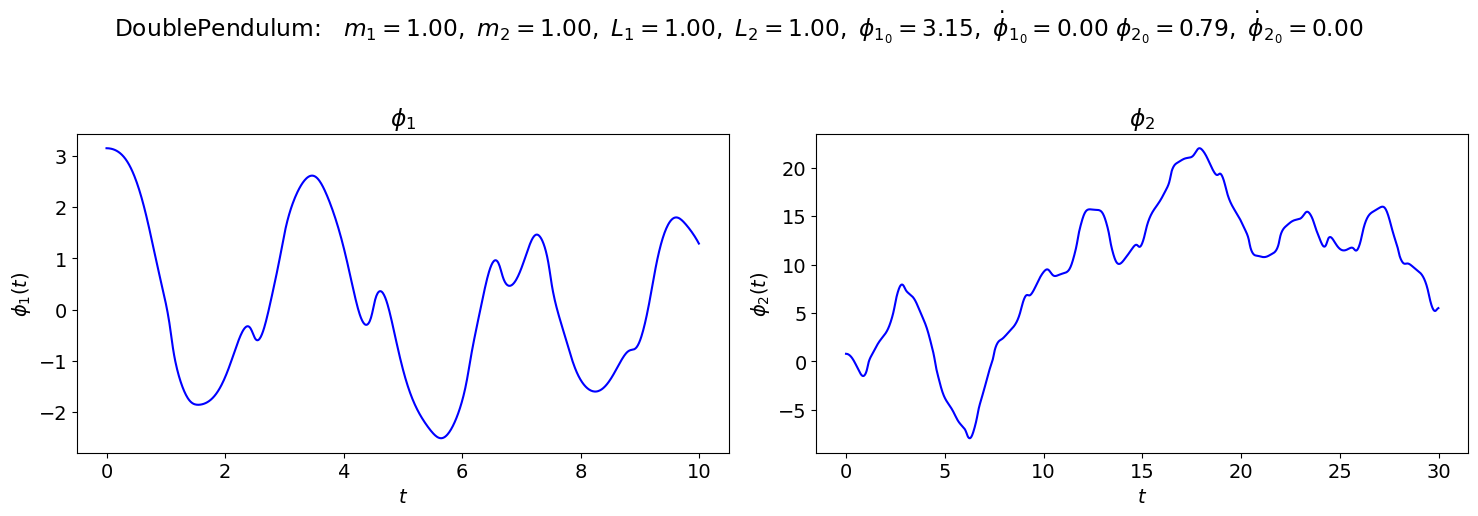

In [40]:
# initial conditions specified
phi_1_0 = np.pi + 0.01
phi_dot_1_0 = 0.0
phi_2_0 = np.pi / 4.
phi_dot_2_0 = 0.0
phi_1, phi_2, phi_dot_1, phi_dot_2 = p1.solve_ode(t_pts, phi_1_0, phi_dot_1_0, phi_2_0, phi_dot_2_0)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'DoublePendulum:  ' + \
                rf' $m_1 = {m1:.2f},$' + \
                rf' $m_2 = {m2:.2f},$' + \
                rf' $L_1 = {L1:.2f},$' + \
                rf' $L_2 = {L2:.2f},$' + \
                rf' $\phi_{{1_0}} = {phi_1_0:.2f},$' + \
                rf' $\dot\phi_{{1_0}} = {phi_dot_1_0:.2f}$' + \
                rf' $\phi_{{2_0}} = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_{{2_0}} = {phi_dot_2_0:.2f}$'
#                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: plot from t=0 to t=10   
ax_a = fig.add_subplot(1,2,1)                  

start, stop = start_stop_indices(t_pts, 0., 10.)    
plot_y_vs_x(t_pts[start : stop], phi_1[start : stop], 
            axis_labels=phi_1_vs_time_labels, 
            color='blue',
            label=None, 
            title=rf'$\phi_1$', 
            ax=ax_a)    
                              
# second plot: state space plot from t=0 to t=10   
ax_b = fig.add_subplot(1,2,2)                  

start, stop = start_stop_indices(t_pts, 0., 30.)    
plot_y_vs_x(t_pts[start : stop], phi_2[start : stop], 
            axis_labels=phi_2_vs_time_labels, 
            color='blue',
            label=None, 
            title=rf'$\phi_2$', 
            ax=ax_b)     

fig.tight_layout()
#fig.savefig('Figure_12.2.png', bbox_inches='tight')  # always bbox_inches='tight'

## Bifurcation Diagrams
To show the system is chaotic, we make bifurcation diagrams for both $\phi_1$ and $\phi_2$ and see if they have a positive slope

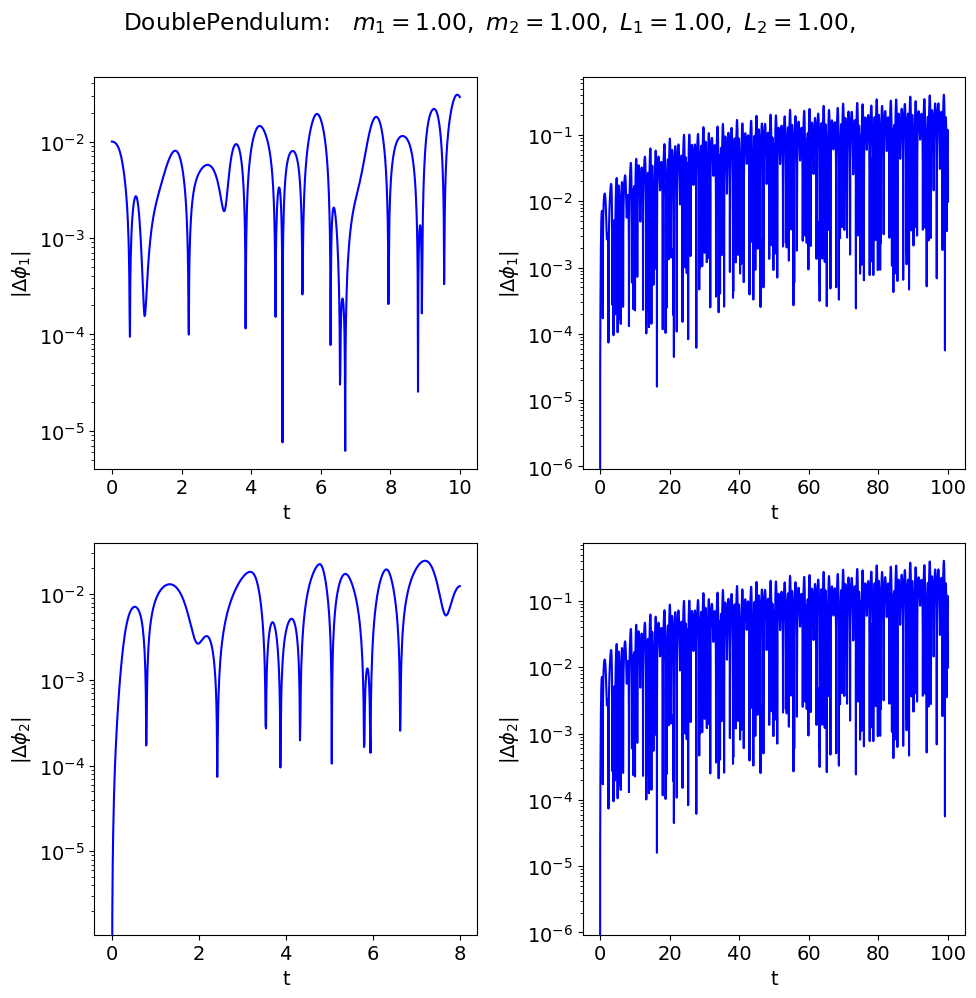

In [42]:
# Labels for individual plot axes
Delta_phi_1_vs_time_labels = (r'$t$', r'$\Delta\phi_1(t)$')
Delta_phi_2_vs_time_labels = (r'$t$', r'$\Delta\phi_2(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

# make a plot of Delta phi for same double pendulum but two different initial conds
phi_1i_0 = np.pi /3.
phi_dot_1i_0 = 0.0
phi_2i_0 = np.pi / 4.
phi_dot_2i_0 = 0.0
phi_1i, phi_2i, phi_dot_1i, phi_dot_2i = p1.solve_ode(t_pts, phi_1i_0, phi_dot_1i_0, phi_2i_0, phi_dot_2i_0)

phi_1j_0 = np.pi /3. + 0.01 # 0.01 radians higher
phi_dot_1j_0 = 0.0
phi_2j_0 = np.pi / 4.
phi_dot_2j_0 = 0.0
phi_1j, phi_2j, phi_dot_1j, phi_dot_2j = p1.solve_ode(t_pts, phi_1j_0, phi_dot_1j_0, phi_2j_0, phi_dot_2j_0)

# Calculate the absolute value of \phi_1j - \phi_1i
Delta_phi_1 = np.fabs(phi_1j - phi_1i)

# Calculate the absolute value of \phi_2j - \phi_2i
Delta_phi_2 = np.fabs(phi_2j - phi_2i)

# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

# start the plot!
fig = plt.figure(figsize=(10,10))
overall_title = 'DoublePendulum:  ' + \
                rf' $m_1 = {m1:.2f},$' + \
                rf' $m_2 = {m2:.2f},$' + \
                rf' $L_1 = {L1:.2f},$' + \
                rf' $L_2 = {L2:.2f},$'
fig.suptitle(overall_title, va='baseline')

# Four plots: plot from t=0 to t=8 and another from t=0 to t=100 for both phi_1 and phi_2
ax_a = fig.add_subplot(2,2,1)                  

start, stop = start_stop_indices(t_pts, 0., 10.)
ax_a.semilogy(t_pts[start : stop], Delta_phi_1[start : stop], 
            color='blue', label=None)    
ax_a.set_xlabel('t')
ax_a.set_ylabel(r'$|\Delta\phi_1|$')

ax_b = fig.add_subplot(2,2,2)                  

start, stop = start_stop_indices(t_pts, 0., 100.)
plot_y_vs_x(t_pts[start : stop], Delta_phi_2[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_b.set_xlabel('t')
ax_b.set_ylabel(r'$|\Delta\phi_1|$')

ax_c = fig.add_subplot(2,2,3)                  

start, stop = start_stop_indices(t_pts, 0., 8.)
plot_y_vs_x(t_pts[start : stop], Delta_phi_2[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_c.set_xlabel('t')
ax_c.set_ylabel(r'$|\Delta\phi_2|$')

ax_d = fig.add_subplot(2,2,4)                  

start, stop = start_stop_indices(t_pts, 0., 100.)
plot_y_vs_x(t_pts[start : stop], Delta_phi_2[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_d.set_xlabel('t')
ax_d.set_ylabel(r'$|\Delta\phi_2|$')
                              
fig.tight_layout()
# always bbox_inches='tight' for best results.  Further adjustments also.
#fig.savefig('figure_12.11.png', bbox_inches='tight')